In [2]:
# %load dm_test.py
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare 
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion 
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power 
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than 
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################


def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt


In [6]:
import pandas as pd
import numpy as np
ldmcmcres = np.loadtxt('predictions.txt')
datadmin=3.9
datadmax = 10.66667
ldmcmc = ldmcmcres*(datadmax-datadmin)+datadmin
ldmcmc = ldmcmc[:-2]

In [74]:
ldmcmcres2 = np.loadtxt('pred2.txt')
ldmcmc2 = ldmcmcres2*(datadmax-datadmin)+datadmin
ldmcmc2 = ldmcmc2[:-2]


ldmcmcres3 = np.loadtxt('pred3.txt')
ldmcmc3 = ldmcmcres3*(datadmax-datadmin)+datadmin
ldmcmc3 = ldmcmc3[:-2]

ldmcmcres4 = np.loadtxt('pred4.txt')
ldmcmc4 = ldmcmcres4*(datadmax-datadmin)+datadmin
ldmcmc4 = ldmcmc4[:-2]

ldavg = (ldmcmc3 + ldmcmc1 +ldmcmc2 + ldmcmc4)/4
ldavg

array([ 5.12234819,  5.01778622,  4.87986457,  4.8378943 ,  4.89576624,
        4.84425497,  4.83133063,  4.76068659,  4.80402711,  4.86188214,
        5.24402983,  5.5880135 ,  6.2012768 ,  6.89284739,  7.94939524,
        8.65336576,  8.89848838,  9.08238955,  9.13016224,  9.0130481 ,
        8.85996911,  8.72038962,  8.47501325,  8.21914854,  8.27395857,
        8.11297949,  7.67054077,  7.44148899,  7.29658076,  7.15576635,
        7.08272015,  6.96942918])

In [75]:
mcmcres = np.loadtxt('predictionsFNN.txt')
mcmcres = mcmcres [:-2]
mcmc = mcmcres*(datadmax-datadmin)+datadmin

In [76]:


arima = pd.read_csv('arimapred.csv')
arima = np.asarray(arima.iloc[:,1])
#arima = list(arima)

pc = np.loadtxt('Pcpred.txt')

pc = pc[:-1]

pcsquare = np.loadtxt('pcsquare.txt')
pcsquare = pcsquare[:-1]

bayvar = np.loadtxt('bvarpreds.txt')
bayvar = bayvar[:-2]
var = pd.read_csv('varpred.csv')
var = np.asarray(var.iloc[:,1])

ols = pd.read_csv('Olspred.csv')
ols = np.asarray(ols.iloc[:-1,1])

test = pd.read_csv('evaluation.csv')
test = np.asarray(test.iloc[:,1])


lstm = pd.read_csv('lstmpred.csv')
lstm = np.asarray(lstm.iloc[:-2,1])

ldmcmc1 = np.loadtxt('pred1.txt')
ldmcmc1 = ldmcmcres*(datadmax-datadmin)+datadmin
ldmcmc1 = ldmcmc1[:-2]
ldmcmc1

array([ 5.08125758,  5.06968658,  4.81052312,  4.84442413,  4.9119555 ,
        4.88949015,  4.94876618,  4.88082882,  5.18093063,  5.09973059,
        5.69296455,  6.11168609,  6.92720516,  7.14448293,  8.20610579,
        9.14051525,  9.43567739,  9.34202668,  9.45909007,  9.21589595,
        9.19958828,  9.22347462,  9.20831728,  8.89623846,  8.7738294 ,
        8.83939843,  8.7027117 ,  8.32722918,  8.33846185,  8.0193457 ,
        8.00994002,  7.96115233])

In [77]:
dm_test(test, lstm,ldmcmc, h = 1, crit="MSE", power = 2)


dm_return(DM=-2.054734985437349, p_value=0.048415670072024485)

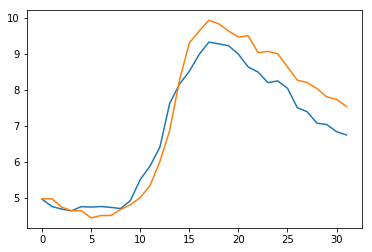

In [95]:
plt.plot(ldmcmc4)
plt.plot(test)
plt.show()

In [98]:
#ME
olsme = (ols - test).mean()
arimame = (arima-test).mean()
varme = (var-test).mean()
pcme = (pc-test).mean()
lstmme = (lstm-test).mean()
#compbvarme = (compbv -test).mean()
ldmcmcme = (ldmcmc - test).mean()
bayvarme = (bayvar -test).mean()
mcmcme = (mcmc - test).mean()
pcsquareme = (pcsquare -test).mean()

print(np.sqrt(((ldavg-test)**2).mean()))

0.524096198173


In [80]:
lstmme

-0.18887027812500001

In [81]:
pcsquareme

-0.01282897570454794

In [82]:
bayvar

array([  5.35294 ,   4.657479,   5.068112,   5.094525,   4.465746,
         4.828761,   4.813276,   4.190898,   4.774795,   4.556511,
         5.198085,   5.457892,   5.630637,   6.013482,   7.205564,
         7.5815  ,  10.078324,  10.165375,  10.097573,  10.367738,
         9.755776,   9.461092,   9.114393,   9.48235 ,   8.791041,
         9.137733,   9.068542,   8.133353,   7.80312 ,   7.976946,
         7.747597,   7.524992])

### Seaborn


In [83]:
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

dates = pd.read_csv('dates.csv', header = None)

In [318]:
dates = dates.iloc[:-1,1]
dates

0     2005-Q3
1     2005-Q4
2     2006-Q1
3     2006-Q2
4     2006-Q3
5     2006-Q4
6     2007-Q1
7     2007-Q2
8     2007-Q3
9     2007-Q4
10    2008-Q1
11    2008-Q2
12    2008-Q3
13    2008-Q4
14    2009-Q1
15    2009-Q2
16    2009-Q3
17    2009-Q4
18    2010-Q1
19    2010-Q2
20    2010-Q3
21    2010-Q4
22    2011-Q1
23    2011-Q2
24    2011-Q3
25    2011-Q4
26    2012-Q1
27    2012-Q2
28    2012-Q3
29    2012-Q4
30    2013-Q1
31    2013-Q2
Name: 1, dtype: object

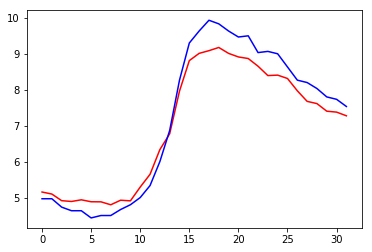

In [53]:
preds = pd.DataFrame([ols, arima, var, pc,pcsquare, bayvar, ldmcmc, mcmc,test])
plt.plot(ldavg, 'r')
plt.plot(test, 'b')
plt.show()

In [320]:

preds = preds.T
preds.columns = ['ols', 'arima', 'var', 'pc','pcsquare', 'bayvar', 'ldmcmc', 'mcmc','test']

In [346]:
preds.index = dates
preds.index.name = 'dates'


#sns.set()

ax = plt.plot(dates,preds['ols'])
#[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
#for label in ax.xaxis.get_ticklabels()[::2]:
    #label.set_visible(False)
#ax.xaxis.set_major_locator(years)
#plt.locator_params(tight=True, nbins=4)
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

In [344]:
print(ax.xaxis)

AttributeError: 'list' object has no attribute 'xaxis'

In [347]:
dates2 = pd.date_range('9/1/2005', periods=32, freq='q')
dates2 = pd.DataFrame(dates2)
print(dates2)


            0
0  2005-09-30
1  2005-12-31
2  2006-03-31
3  2006-06-30
4  2006-09-30
5  2006-12-31
6  2007-03-31
7  2007-06-30
8  2007-09-30
9  2007-12-31
10 2008-03-31
11 2008-06-30
12 2008-09-30
13 2008-12-31
14 2009-03-31
15 2009-06-30
16 2009-09-30
17 2009-12-31
18 2010-03-31
19 2010-06-30
20 2010-09-30
21 2010-12-31
22 2011-03-31
23 2011-06-30
24 2011-09-30
25 2011-12-31
26 2012-03-31
27 2012-06-30
28 2012-09-30
29 2012-12-31
30 2013-03-31
31 2013-06-30


In [217]:
sns.tsplot(data =preds, time = 'var')

/home/wgrebner/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


ValueError: setting an array element with a sequence.